In [123]:
import random
import numpy as np
from typing import List
import time
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from scipy.stats import ks_2samp, kstest, kurtosis
#from fbm import FBM
#from tensorflow.keras.datasets import mnist
from pathlib import Path
import os
import warnings
warnings.filterwarnings("ignore")

## Schätzung der Drift-Funktion mit dem Nadaraya-Watson-Schätzer und Kernel-Methoden

Nadaraya-Watson-Schätzer:

$$
\hat{a}(t, x; x_i) = \frac{1}{t_{i+1} - t} \frac{\sum_{m=1}^{M} (X_{t_{i+1}}^{(m)} - x) F_i(t, X_{t_i}^{(m)}, x, X_{ t_{i+1}}^{(m)}) \prod_{j=1}^{i} K_h(x_j - X_{ t_j}^{(m)})}{\sum_{m=1}^{M} F_i(t, X_{t_i}^{(m)}, x, X_{ t_{i+1}}^{(m)}) \prod_{j=1}^{i} K_h(x_j - X_{ t_j}^{(m)})},
$$

mit $F_i(t, x_{i}, x, x_{i+1}) = \exp \left( -\frac{|x_{i+1} - x|^2}{2(t_{i+1} - t)} + \frac{|x_{i+1} - x_i|^2}{2(t_{i+1} - t_i)} \right)$.
 
In der Methode `simulate_kernel` wird der Nadaraya-Watson-Schätzer verwendet, um die Drift-Funktion zu approximieren. Dieser Schätzer basiert auf einer Kernel-Methode, die es ermöglicht, die bedingten Erwartungswerte unter der Zielverteilung $\mu$ direkt aus Datenproben zu schätzen. Die Kernel-Methode verwendet entweder den Quartic-Kernel oder den Gausschen Kernel.

Der Quartic-Kernel wird durch die Funktion

$K_h(x) = \frac{1}{h}K\left(\frac{x}{h}\right)$

mit

$K(x) = \begin{cases} (1 - |x|^2)^2 & \text{falls } |x| \leq 1 \\ 0 & \text{falls } |x| > 1 \end{cases}$

definiert. Dieser Kernel ermöglicht eine adaptive Anpassung der Gewichtungen der Datenproben, wobei $h$, der Abstand zwischen den Datenpunkten, berücksichtigt wird.

Der Gaussche Kernel wird durch die Funktion

$K(x) = \frac{1}{\sqrt{2\pi}H} \exp\left(-\frac{x^2}{2H^2}\right)$

gegeben, wobei $H$ die Varianzparameter ist. Dieser Kernel modelliert die Gewichtungen der Datenproben unter Berücksichtigung der Normalverteilung.


In [49]:
import numpy as np
from tqdm import tqdm

class SchrodingerBridge:
    def __init__(self, distSize, nbpaths, timeSeriesData=None, dimension=None, timeSeriesDataVector=None):
        self.distSize = distSize
        self.nbpaths = nbpaths
        self.dimension = dimension

        if timeSeriesData is not None:
            self.timeSeriesData = np.array(timeSeriesData)
            self.timeSeries = np.zeros((distSize + 1,))
            self.timeSeries[0] = self.timeSeriesData[0, 0]
        else:
            self.timeSeriesData = None
            self.timeSeries = None

        if timeSeriesDataVector is not None:
            self.timeSeriesDataVector = np.array(timeSeriesDataVector)
            self.timeSeriesVector = np.zeros((distSize + 1, dimension))
        else:
            self.timeSeriesDataVector = None
            self.timeSeriesVector = None

        self.weights = np.zeros((nbpaths,))
        self.weights_tilde = np.zeros((nbpaths,))
    
    def __del__(self):
        pass

    def simulate_kernel(self, nbStepsPerDeltati, H, deltati):
        vtimestepEuler = np.arange(0, deltati + deltati/nbStepsPerDeltati, deltati/nbStepsPerDeltati)
        Brownian = np.random.normal(0, 1, self.distSize * (len(vtimestepEuler) - 1))

        timeSeries = np.zeros_like(self.timeSeries)
        timeSeries[0] = self.timeSeries[0]
        X_ = timeSeries[0]
        index_ = 0

        for interval in range(self.distSize):
            for particle in range(self.timeSeriesData.shape[0]):
                if interval == 0:
                    self.weights[particle] = 1.0 / self.nbpaths
                else:
                    self.weights[particle] *= self.kernel(self.timeSeriesData[particle, interval] - X_, H)

                self.weights_tilde[particle] = self.weights[particle] * np.exp((self.timeSeriesData[particle, interval + 1] - X_) ** 2 / (2.0 * deltati))

            for nbtime in range(len(vtimestepEuler) - 1):
                expecY = 0.0
                expecX = 0.0
                timeprev = vtimestepEuler[nbtime]
                timestep = vtimestepEuler[nbtime + 1] - vtimestepEuler[nbtime]

                for particle in range(self.timeSeriesData.shape[0]):
                    if nbtime == 0:
                        expecX += self.weights[particle]
                        expecY += self.weights[particle] * (self.timeSeriesData[particle, interval + 1] - X_)
                    else:
                        termtoadd = -(self.timeSeriesData[particle, interval + 1] - X_) ** 2 / (2.0 * (deltati - timeprev))
                        termtoadd = self.weights_tilde[particle] * np.exp(termtoadd)
                        expecX += termtoadd
                        expecY += termtoadd * (self.timeSeriesData[particle, interval + 1] - X_)

                drift = (1.0 / (deltati - timeprev)) * (expecY / expecX) if expecX > 0.0 else 0.0
                X_ += drift * timestep + Brownian[index_] * np.sqrt(timestep)
                index_ += 1

            timeSeries[interval + 1] = X_

        return timeSeries

    def simulate_kernel_vectorized(self, nbStepsPerDeltati, H, deltati):
        vtimestepEuler = np.arange(0, deltati + deltati/nbStepsPerDeltati, deltati/nbStepsPerDeltati)
        Brownian = np.random.normal(0, 1, self.distSize * self.dimension * (len(vtimestepEuler) - 1))

        X_ = np.zeros(self.dimension)
        index_ = 0

        for interval in range(self.distSize):
            for particle in range(self.timeSeriesDataVector.shape[0]):
                if interval == 0:
                    self.weights[particle] = 1.0 / self.nbpaths
                else:
                    for i in range(self.dimension):
                        self.weights[particle] *= self.kernel(self.timeSeriesDataVector[particle, interval, i] - X_[i], H)

                self.weights_tilde[particle] = self.weights[particle]
                for i in range(self.dimension):
                    self.weights_tilde[particle] *= np.exp((self.timeSeriesDataVector[particle, interval + 1, i] - X_[i]) ** 2 / (2.0 * deltati))

            for nbtime in range(len(vtimestepEuler) - 1):
                numerator = np.zeros(self.dimension)
                expecX = 0.0
                timeprev = vtimestepEuler[nbtime]
                timestep = vtimestepEuler[nbtime + 1] - vtimestepEuler[nbtime]

                for particle in range(self.timeSeriesDataVector.shape[0]):
                    if nbtime == 0:
                        expecX += self.weights[particle]
                        for i in range(self.dimension):
                            numerator[i] += self.weights[particle] * (self.timeSeriesDataVector[particle, interval + 1, i] - X_[i])
                    else:
                        termtoadd = 0.0
                        for i in range(self.dimension):
                            termtoadd += (self.timeSeriesDataVector[particle, interval + 1, i] - X_[i]) ** 2

                        termtoadd = self.weights_tilde[particle] * np.exp(-termtoadd / (2.0 * (deltati - timeprev)))
                        expecX += termtoadd

                        for i in range(self.dimension):
                            numerator[i] += termtoadd * (self.timeSeriesDataVector[particle, interval + 1, i] - X_[i])

                timestepsqrt = np.sqrt(timestep)
                for i in range(self.dimension):
                    drift = (1.0 / (deltati - timeprev)) * (numerator[i] / expecX) if expecX > 0.0 else 0.0
                    X_[i] += drift * timestep + Brownian[index_] * timestepsqrt
                    index_ += 1

            self.timeSeriesVector[interval + 1] = X_

        return self.timeSeriesVector

    @staticmethod
    def kernel(x, H):
        if abs(x) < H:
            return (H * H - x * x) ** 2
        else:
            return 0.0

    @staticmethod
    def schedule(timeEuler, maturity, timestep):
        time_ = 0.0
        while time_ < maturity:
            timeEuler.append(time_)
            time_ += timestep
        timeEuler.append(maturity)



## Simulation der Schrödinger-Brücke

Die Funktion `simulateSB` dient dazu, eine Schrödinger-Brücke zu simulieren. Dabei werden folgende Parameter verwendet:
- `N`: Die Anzahl der Zeitintervalle.
- `M`: Die Anzahl der Pfade.
- `Data`: Die Datenmatrix der beobachteten Zeitreihen.
- `deltati`: Die Zeitschrittweite.
- `H`: Die Varianzparameter für den Kernel.
- `nbStepsPerDeltati`: Die Anzahl der Schritte pro Zeitschritt.
- `numberOfSamples`: Die Anzahl der zu simulierenden Brücken.

Die Funktion erstellt eine Instanz der Klasse `SchrodingerBridge` mit den angegebenen Parametern und führt dann die Simulation der Schrödinger-Brücke durch. Die resultierende Simulation wird als Numpy-Array zurückgegeben.


In [51]:
def simulateSB(N, M, Data, deltati, H, nbStepsPerDeltati, numberOfSamples):
    assert Data.shape == (M, N+1)
    assert H > 0
    
    simulator = SchrodingerBridge(N, M, Data)

    simu = []
    for i in tqdm(range(numberOfSamples)):
        simu.append(simulator.simulate_kernel(nbStepsPerDeltati, H, deltati))
    simu = np.array(simu)
    
    return simu

## Generierung einer Zeitreihe

Eine Zeitreihe wird gemäß eines autoregressiven (AR) Modells generiert. Das Modell ist wie folgt definiert:

\begin{align*}
X_{t_1} &= b + \epsilon_1 \\
X_{t_2} &= \beta_1 X_{t_1} + \epsilon_2 \\
X_{t_3} &= \beta_2 X_{t_2} + \sqrt{|X_{t_1}|} + \epsilon_3
\end{align*}

Dabei sind die Rauschkomponenten $\epsilon_i$ jeweils unabhängig voneinander und normalverteilt mit den Parametern $\mu = 0$ und $\sigma_i^2$ (für $i = 1,2,3$). Die Modellparameter sind $b = 0.7$, $\sigma_1 = 0.1$, $\sigma_2 = \sigma_3 = 0.05$ sowie $\beta_1 = \beta_2 = -1$.


Dabei sind die Rauschkomponenten $\epsilon_i$ (engl. white noise) jeweils unabhängig voneinander und normalverteilt mit den Parametern $\mu = 0$ und $\sigma_i^2$ (für $i = 1,2,3$). Die Modellparameter sind $b = 0.7$, $\sigma_1 = 0.1$, $\sigma_2 = \sigma_3 = 0.05$ sowie $\beta_1 = \beta_2 = -1$.
Für die Simulation werden Datensätze der Größe $M = 1000$ für das AR-Modell verwendet. Die Drift-Funktion der Schrödinger-Brücke wird mit einem Kern mit einer Bandbreite von $h = 0.05$ geschätzt und mithilfe des Euler-Verfahrens mit $N\pi = 100$ simuliert.


In [52]:
# Number of time steps and number of samples
M = 1000
N = 3

# Generate true time series
X = np.zeros((M, N+1))
X[:,0] = 0.
X[:,1] = np.random.normal(loc=0.7, scale=0.1, size=M)
X[:,2] = - X[:,1] + np.random.normal(scale=0.05, size=M)
X[:,3] = - X[:,2] + np.sqrt(X[:,1]) + np.random.normal(scale=0.05, size=M)

In [ ]:
M, N, X.shape

## Simulation der Schrödinger-Brücke

Es wird eine Schrödinger-Brücke simuliert mit folgenden Parametern:
- Anzahl der Zeitintervalle: $N = 3$
- Anzahl der Proben: $M = 1000$
- Beobachtete Datenmatrix: $X$
- Zeitschrittweite: $\frac{7}{252}$
- Varianzparameter für den Kernel: $H = 0.05$
- Anzahl der Schritte pro Zeitschritt: $100$
- Anzahl der zu simulierenden Brücken: $1000$

In [54]:
# Simulate
simu = simulateSB(
    N=N, 
    M=M,
    Data=X, 
    deltati=7./252., 
    H=0.05, 
    nbStepsPerDeltati=100, 
    numberOfSamples=1000
)

100%|███████████████████████████████████████████████████████| 1000/1000 [06:06<00:00,  2.73it/s]


In [ ]:
X.shape, simu.shape

### Verteilungsplot

Es wird ein gemeinsamer Verteilungsplot für die Zufallsvariablen $X_{t_i}$ und $X_{t_j}$, wobei $i,j\in \{1,2,3\}$ erstellt. Dabei werden die echten Daten und die simulierten Daten der Schrödinger-Brücke dargestellt. Die Konturdiagramme zeigen die Dichteschätzungen der Verteilungen.

In [ ]:
# Add simulated and true time series distributions to dataframe
df_data_SBTS = pd.DataFrame()
df_data_SBTS["X_1"] = X[:500,1].tolist() + simu[:500,1].tolist()
df_data_SBTS["X_2"] = X[:500,2].tolist() + simu[:500,2].tolist()
df_data_SBTS["X_3"] = X[:500,3].tolist() + simu[:500,3].tolist()
df_data_SBTS["type"] = ["Data"]*500 + ["SBTS"]*500


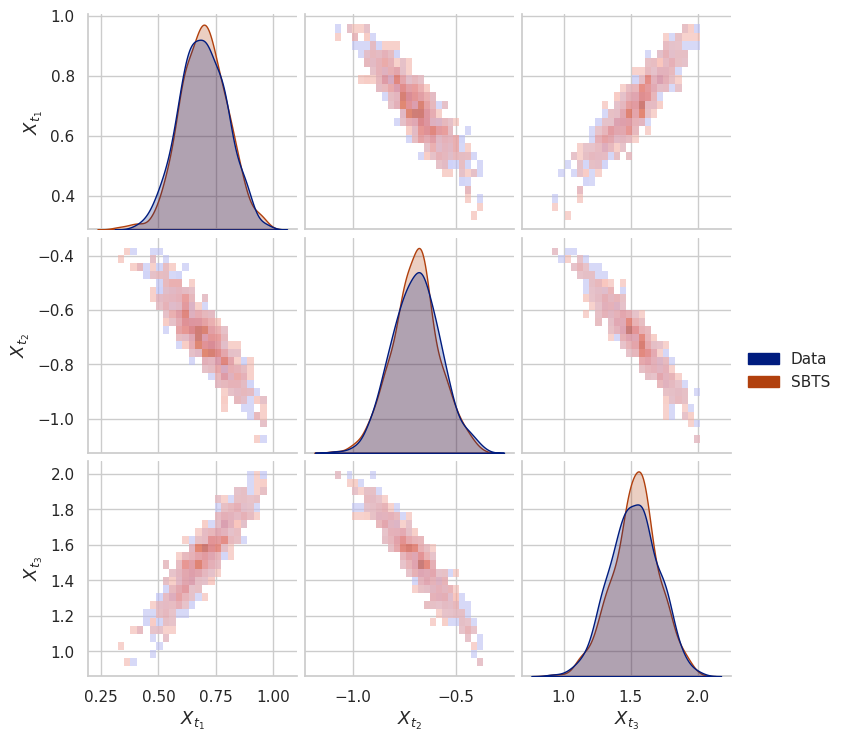

In [93]:
# Plot distribution
sns.set(style="whitegrid")

# Using sns.pairplot to plot all pairs of X_1, X_2, X_3
pair_plot = sns.pairplot(
    data=df_data_SBTS,
    vars=["X_1", "X_2", "X_3"], 
    hue="type",
    palette="dark", 
    kind="hist",  # 'kde' or 'scatter'
    diag_kind="kde",  # KDE plots on the diagonal
    plot_kws={'alpha': 0.6},
    
)

# Set axis labels
pair_plot.axes[0,0].set_ylabel(r"$X_{t_1}$", fontsize=13)
pair_plot.axes[1,0].set_ylabel(r"$X_{t_2}$", fontsize=13)
pair_plot.axes[2,0].set_ylabel(r"$X_{t_3}$", fontsize=13)
pair_plot.axes[2,0].set_xlabel(r"$X_{t_1}$", fontsize=13)
pair_plot.axes[2,1].set_xlabel(r"$X_{t_2}$", fontsize=13)
pair_plot.axes[2,2].set_xlabel(r"$X_{t_3}$", fontsize=13)

# Improve legend
pair_plot._legend.set_title('')
plt.setp(pair_plot._legend.get_texts(), fontsize=11)  # set text size

plt.show()

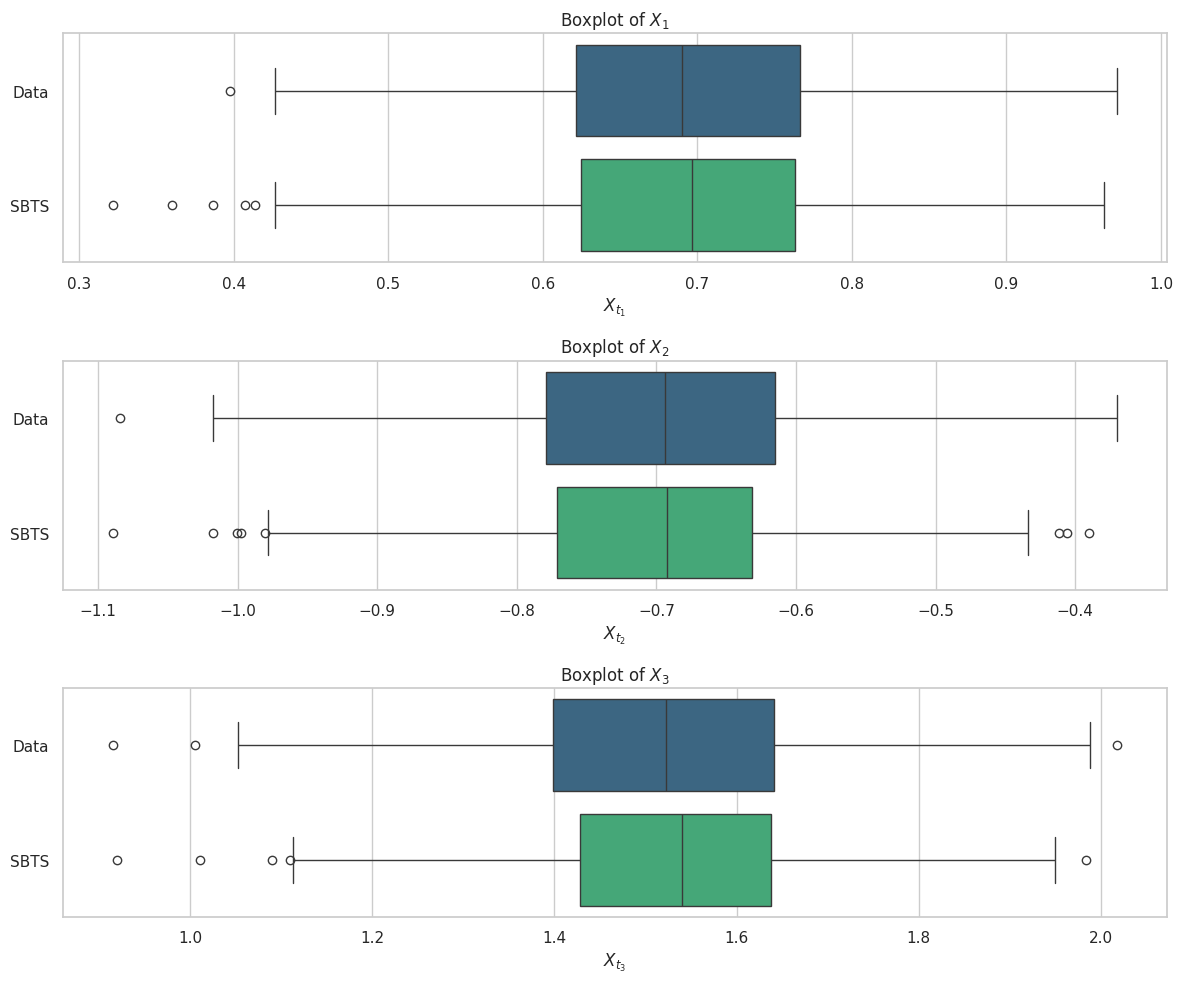

In [111]:

sns.set(style="whitegrid")


plt.figure(figsize=(12, 10))

# Boxplot  X_1
plt.subplot(3, 1, 1)  # 3 Zeilen, 1 Spalte, 1. Position
sns.boxplot(data=df_data_SBTS, x='X_1', y='type', orient='h', palette='viridis')
plt.xlabel('$X_{t_1}$')
plt.ylabel('')
plt.title('Boxplot of $X_1$')

# Boxplot  X_2
plt.subplot(3, 1, 2)  # 3 Zeilen, 1 Spalte, 2. Position
sns.boxplot(data=df_data_SBTS, x='X_2', y='type', orient='h', palette='viridis')
plt.xlabel('$X_{t_2}$')
plt.ylabel('')
plt.title('Boxplot of $X_2$')

# Boxplot  X_3
plt.subplot(3, 1, 3)  # 3 Zeilen, 1 Spalte, 3. Position
sns.boxplot(data=df_data_SBTS, x='X_3', y='type', orient='h', palette='viridis')
plt.xlabel('$X_{t_3}$')
plt.ylabel('')
plt.title('Boxplot of $X_3$')


plt.tight_layout()
plt.show()


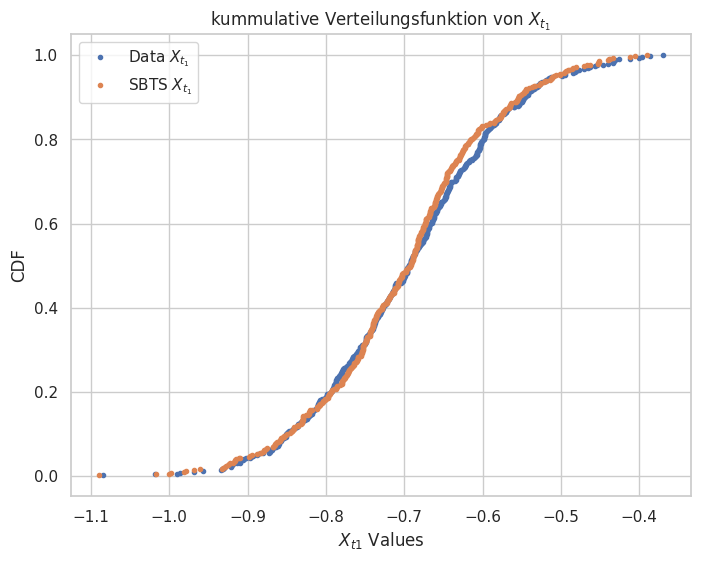

In [118]:
x='X_2'


# Daten vorbereiten
data_x1 = df_data_SBTS[df_data_SBTS['type'] == 'Data'][x]
sbts_x1 = df_data_SBTS[df_data_SBTS['type'] == 'SBTS'][x]

# Daten für den CDF-Plot kumultative Verteilungsfunktion
data_x1_sorted = np.sort(data_x1)
sbts_x1_sorted = np.sort(sbts_x1)
p_data = np.arange(1, len(data_x1_sorted)+1) / len(data_x1_sorted)
p_sbts = np.arange(1, len(sbts_x1_sorted)+1) / len(sbts_x1_sorted)

# CDF plot erstellen
plt.figure(figsize=(8, 6))
plt.plot(data_x1_sorted, p_data, label='Data $X_{t_1}$', marker='.', linestyle='none')
plt.plot(sbts_x1_sorted, p_sbts, label='SBTS $X_{t_1}$', marker='.', linestyle='none')
plt.title('kummulative Verteilungsfunktion von $X_{t_1}$')
plt.xlabel('$X_{t1}$ Values')
plt.ylabel('CDF')
plt.legend()
plt.grid(True)
plt.show()


### Kolmogorow-Smirnow-Test



1. Der Kolmogorov-Smirnov-Test wird zwischen den Daten `X[:,i]` und den simulierten Daten `simu[:,i]` durchgeführt, und der p-Wert wird im entsprechenden Eintrag von `df_stats_quantiles['p-value']` gespeichert.

2. Die 5%- und 95%-Quantile werden für die Daten `X[:,i]` und die simulierten Daten `simu[:,i]` berechnet und in den entsprechenden Einträgen von `df_stats_quantiles` gespeichert.


In [94]:
df_stats_quantiles = pd.DataFrame(
    columns=[
    "p-value", 
    "5%-quantile data", 
    "5%-quantile SB", 
    "95%-quantile data", 
    "95%-quantile SB"
    ],
    index=[1,2,3]
)

In [16]:
for i in df_stats_quantiles.index:
    
    # Kolmogorov Smirnov test
    df_stats_quantiles['p-value'].loc[i] = kstest(rvs=X[:,i], cdf=simu[:,i])[1]
    
    # Quantiles
    df_stats_quantiles['5%-quantile data'].loc[i] = np.quantile(X[:,i], 0.05)
    df_stats_quantiles['95%-quantile data'].loc[i] = np.quantile(X[:,i], 0.95)
    df_stats_quantiles['5%-quantile SB'].loc[i] = np.quantile(simu[:,i], 0.05)
    df_stats_quantiles['95%-quantile SB'].loc[i] = np.quantile(simu[:,i], 0.95)

In [18]:
df_stats_quantiles

,p-value,5%-quantile data,5%-quantile SB,95%-quantile data,95%-quantile SB
1,0.500567,0.534942,0.529802,0.858688,0.851271
2,0.148365,-0.884443,-0.858514,-0.520131,-0.518373
3,0.400634,1.251101,1.240968,1.815977,1.787958


Berechnung der Korrelationsmatrizen für die Daten und die simulierten Daten, sowie die Differenz zwischen ihnen:

In [ ]:
data_correlation_matrix = np.corrcoef(X[:,1:].T)
SB_correlation_matrix = np.corrcoef(simu[:,1:].T)

data_correlation_df = pd.DataFrame(data_correlation_matrix)
SB_correlation_df = pd.DataFrame(SB_correlation_matrix)
difference_df = pd.DataFrame((data_correlation_matrix - SB_correlation_matrix).round(3))

combined_df = pd.concat([data_correlation_df, SB_correlation_df, difference_df], axis=1)
combined_df

## Generierung von GARCH-Zeitreihen

In diesem Abschnitt wird ein GARCH-Modell verwendet, um Zeitreihen zu generieren. Ein GARCH-Modell (Generalized Autoregressive Conditional Heteroskedasticity) ist ein statistisches Modell für die Volatilität von Finanzzeitreihen.

### GARCH-Modell

Wir betrachten ein GARCH-Modell mit den folgenden Parametern:
- $ X_{t+1} = \sigma_{t+1} \epsilon_{t+1} $
- $ \sigma^2_{t+1} = \alpha_0 + \alpha_1 X^2_t + \alpha_2 X^2_{t-1} $
- $ \alpha_0 = 5 $, $ \alpha_1 = 0.4 $, $ \alpha_2 = 0.1 $
- Die Rauschkomponenten $ \epsilon_{t} $ sind unabhängig und identisch normalverteilt mit einem Mittelwert von 0 und einer Standardabweichung von 0.1.

### Generierung von Zeitreihen

Die Größe der Zeitreihen beträgt $ N = 60 $. Um eine stationäre Verteilung zu erreichen, werden zunächst 50 Schritte durchlaufen, bevor die eigentliche Zeitreihe beginnt.

### Hyperparameter

Für das Training und die Generierung von SBTS (Schrödinger Bridge Time Series) werden die folgenden Hyperparameter verwendet:
- Anzahl der Zeitreihen: $ M = 1000 $
- Anzahl der Schritte für die Euler-Diskretisierung: $ N_{\pi} = 100 $
- Bandbreite für die Kernel-Schätzung: $ h = 0.2 $ (größer als für das AR-Modell, da der GARCH-Prozess von Natur aus volatiler ist).


In [112]:
# Number of time steps and number of samples
M = 1000
N = 60

# Generate Garch time series
alpha_0 = 5.
alpha_1 =  0.4
alpha_2 = 0.1

def Garch_sample(alpha_0, alpha_1, alpha_2):
    
    time_series = list()
    x_next = 0.0
    x_prev = 0.0
    
    for t in range(N+50):
        
        # Diffuse over (for example) 50 time steps to achieve stationarity
        if t>=50:
            time_series.append(x_next)
        
        # Compute volatility
        sigma = np.sqrt(alpha_0 + alpha_1 * x_next**2 + alpha_2 * x_prev**2)
        x_prev = x_next
        x_next = sigma * np.random.normal(scale=0.1)
        
    return [0.0] + time_series

X = np.array([Garch_sample(alpha_0, alpha_1, alpha_2) for i in range(M)])

In [21]:
M, N, X.shape

(1000, 60, (1000, 61))

In [22]:
simu = simulateSB(
    N = N, 
    M = M,
    Data = X, 
    deltati = 7./252., 
    H = 0.2, 
    nbStepsPerDeltati = 100, 
    numberOfSamples = 1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

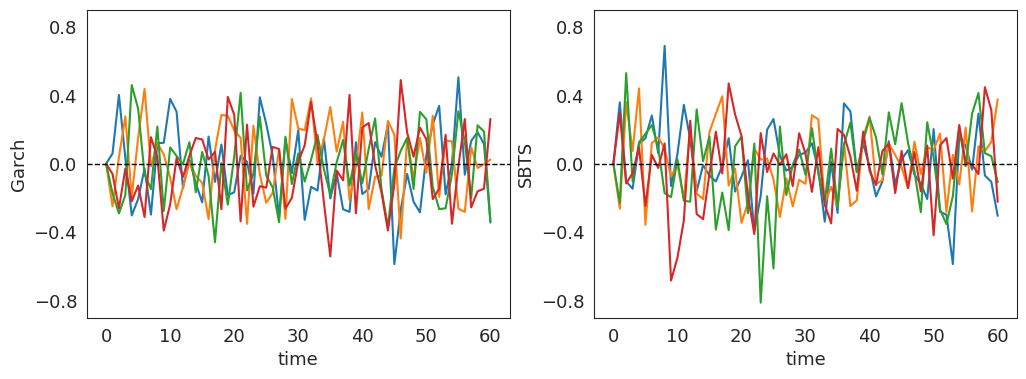

In [23]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Select random paths
for i in range(4):
    j = np.random.randint(len(simu))
    ax[0].plot(X[j], linewidth=1.5)
    ax[1].plot(simu[j], linewidth=1.5)
    
ax[0].axhline(0, linewidth=1, linestyle="--", color='k')
ax[0].set_xlabel('time')
ax[0].set_ylabel('Garch')
ax[0].set_ylim(-0.9, 0.9)
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[0].set_yticks([-0.8, -0.4, 0, 0.4, 0.8])

ax[1].axhline(0, linewidth=1, linestyle="--", color='k')
ax[1].set_xlabel('time')
ax[1].set_ylabel('SBTS')
ax[1].set_ylim(-0.9, 0.9)
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[1].set_yticks([-0.8, -0.4, 0, 0.4, 0.8])

### Echte Daten von yfinance

#### Herunterladen von Daten mit der Yahoo Finance API

Die Daten für das Unternehmen AAPL werden von Yahoo Finance heruntergeladen. Der Datumsbereich erstreckt sich von Januar 2010 bis Januar 2020.

#### Erstellung von vielen Beispielen der Apple-Zeitreihe

Es wird ein rollendes Fenster verwendet, um viele Beispiele der Apple-Zeitreihe zu erstellen. Die Fenstergröße beträgt $N = 60$. Die relative Veränderung der Anpassungsschlusskurse wird verwendet.

#### Schrödinger-Brücken-Diffusion der logarithmischen Renditen

Die logarithmischen Renditen der Aktienkurse werden berechnet und dann die Schrödinger-Brücken-Diffusion auf die logarithmischen Renditen angewendet. Die Hyperparameter für die Erzeugung der synthetischen SBTS-Proben sind $N\pi = 100$ und eine Bandbreite von $h = 0.05$.

#### Konvertierung der logarithmischen Renditen

Die simulierten logarithmischen Renditen werden in absolute Preise umgerechnet, indem sie aufsummiert und dann exponentiert werden.
Pfade darstellen.


In [124]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [125]:
# Download data using Yahoo Finance API
start_date = "2010-01-01"
end_date = "2020-01-30"
data = pdr.get_data_yahoo("AAPL", start=start_date, end=end_date)

# Take rolling window to create many samples of apple time series
N = 60
X = np.array([data["Adj Close"].values[i:i+N+1]/data["Adj Close"].values[i] for i in range(len(data)-N)])
M = len(X)

# Get log returns
log_returns = np.zeros((M, N+1))
log_returns[:,1:] = np.diff(np.log(X), axis=1)

[*********************100%%**********************]  1 of 1 completed


In [126]:
# SBTS diffusion of log returns
simu_log_returns = simulateSB(
    N = N, 
    M = log_returns.shape[0],
    Data = log_returns,
    deltati = 2./252.,
    H = 0.05, 
    nbStepsPerDeltati = 100, 
    numberOfSamples = 1000
)

# Convert log returns
simu = np.exp(simu_log_returns.cumsum(axis=1))

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

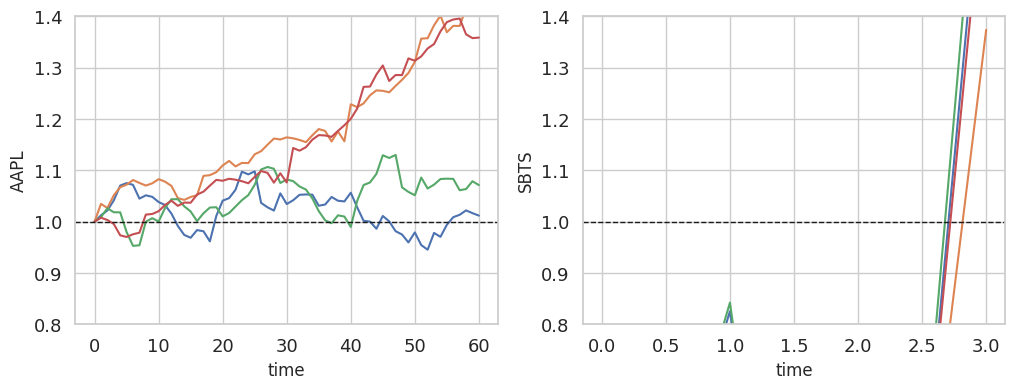

In [127]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Select random paths
for i in range(4):
    ax[0].plot(X[np.random.randint(len(X))], linewidth=1.5)
    ax[1].plot(simu[np.random.randint(len(simu))], linewidth=1.5)
    
ax[0].axhline(1, linewidth=1, linestyle="--", color='k')
ax[1].axhline(1, linewidth=1, linestyle="--", color='k')

ax[0].set_xlabel('time')
ax[0].set_ylabel('AAPL')
ax[0].set_ylim(0.8, 1.4)
ax[0].tick_params(axis='both', which='major', labelsize=13)

ax[1].set_xlabel('time')
ax[1].set_ylabel('SBTS')
ax[1].set_ylim(0.8, 1.4)
ax[1].tick_params(axis='both', which='major', labelsize=13)

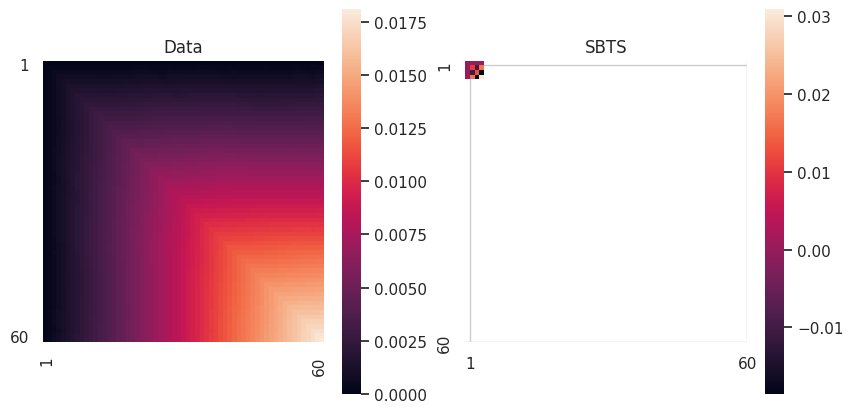

In [128]:
#Covariance Matrix

X_covar = np.cov(X.T)
simu_covar = np.cov(simu.T)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
hm0 = sns.heatmap(X_covar,
                 cbar=True,
                 square=True,
                 ax=ax[0])
ax[0].set_title("Data")
ax[0].set_xticks([1, N], [1, N])
ax[0].set_yticks([1, N], [1, N])
hm1 = sns.heatmap(simu_covar,
                 cbar=True,
                 square=True,
                 ax=ax[1])
ax[1].set_title("SBTS")
ax[1].set_xticks([1, N], [1, N])
ax[1].set_yticks([1, N], [1, N])
plt.show()

In [ ]:
#quadratische Variation

quadratic_var_simu = np.power(np.diff(np.array(simu)[:,]), 2).sum(axis=1)
quadratic_var_X = np.power(np.diff(X[:,]), 2).sum(axis=1)
fig = plt.figure(figsize=(7,5))
sns.distplot(quadratic_var_X, label="Data", color='r')
sns.distplot(quadratic_var_simu, label="SBTS", color='k')
plt.legend()

In [ ]:
#tail

M_max = min(1000, len(simu), len(X)) # used to select a mini-batch of paths

# Compute retruns
simu_returns = np.abs(np.array(simu)[:,-1] - np.array(simu)[:,0])
X_returns = np.abs(np.array(X)[:,-1] - np.array(X)[:,0])
gaussian_returns = np.abs(np.random.normal(loc=np.mean(X_returns), scale=np.std(X_returns), size=M_max))
fig = plt.figure(figsize=(7,5))
df_data_plot = pd.DataFrame()
df_data_plot["returns"] = X_returns[:M_max].tolist() + simu_returns[:M_max].tolist() + gaussian_returns.tolist()
df_data_plot["Legend"] = ["Data"] * M_max + ["SBTS"] * M_max + ["Gaussian"] * M_max
ax = sns.displot(data=df_data_plot, x="returns", hue="Legend", complementary=True, kind="ecdf", palette="brg_r", linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$\mathbb{P}\left(|R| \geq x\right)$", fontsize=15)
plt.xlabel(r"$x$", fontsize=15)
plt.xlim(0.05,5)
ax._legend.get_title().set_text("")

In [ ]:
Path("../data/").mkdir(parents=True, exist_ok=True)

if os.path.exists("../data/data_deephedging.npz"):
    
    print("data already exists")
    
else:

    simu_log_returns = simulateSB(
        N = N, 
        M = log_returns.shape[0],
        Data = log_returns,
        deltati = 2./252.,
        H = 0.05, 
        nbStepsPerDeltati = 100, 
        numberOfSamples = 10000
    )

    simu = np.exp(simu_log_returns.cumsum(axis=1))
    
    np.savez_compressed("../data/data_deephedging.npz", X=X, simu=simu)